# Diabetes 130-US hospitals for years 1999-2008

Este dataset representa 10 años (1999-2008) de atención clínica en 130 hospitales y redes integradas de prestación de servicios de EE. UU. Incluye más de 50 funciones que representan los resultados del paciente y del hospital. Se extrajo información de la base de datos para los ingresos que cumplieron con los siguientes criterios.

(1) Es un ingreso hospitalario (una admisión hospitalaria).

(2) Es un ingreso diabético, es decir, durante el cual se ingresó al sistema cualquier tipo de diabetes como diagnóstico.

(3) La duración de la estancia fue de al menos 1 día y como máximo 14 días.

(4) Se realizaron pruebas de laboratorio durante la estancia.

(5) Se administraron medicamentos durante la estancia.

 

Los datos contienen atributos tales como número de paciente, raza, sexo, edad, tipo de admisión, tiempo en el hospital, especialidad médica del médico que lo admite, número de pruebas de laboratorio realizadas, resultado de la prueba de HbA1c, diagnóstico, cantidad de medicación, medicamentos para diabéticos, cantidad de pacientes ambulatorios , visitas hospitalarias y urgentes en el año anterior a la hospitalización, etc. Para cada registro existe uno de los siguientes resultados:

1. No readmisión;

2. Readmisión en menos de 30 días (esta situación no es buena, porque existe la posibilidad de que el tratamiento aplicado no fue apropiado);

3. Readmisión después de 30 días (esta situación tampoco es buena, sin embargo, la razón podría estar relacionada con el estado del paciente).

### Abordaje propuesto

En este caso propongo abordar este problema desde un sentido supervisado, con el fin de clasificar el resultado de un paciente. 

De acuerdo con lo que leí en el artículo: *Impact of HbA1c Measurement on Hospital Readmission Rates:
Analysis of 70,000 Clinical Database Patient Records* se me ocurre cuatro maneras de construir la variable de respuesta y la población objetivo para el análisis, **las cuales me gustaria discutirlas**:

(1). Predecir la readmisión temprana. En este caso la variable de respuesta sería: Y = 1, si readmisión en menos de 30 días, Y = 0 en otro caso.

(2). Predecir la readmisión temprana, sin tener en cuenta la población de readmisión después de 30 días, es decir: Y = 1, si readmisión en menos de 30 días, Y = 0 no readmisión.

(3). Predecir la readmisión, es decir que: Y = 1, sí readmisión, Y = 0 no readmisión.

(4). Ajustar un modelo multiclase, que permita predecir el resultado en general del paciente.

*Ahora bien, decido abordarlo desde el enfoque del punto (1), con el fin de predecir si el paciente será readmitido de manera temprana o no, y asi identificar los patrones de aquellos que probablemente el tratamiento no funcionó.*

###  Librerias necesarias

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np

from pandas_profiling import ProfileReport   # Reporte descriptivo del dataset
import seaborn as sns                        # libreria para graficos 
import matplotlib.pyplot as plt              # libreria para graficos

from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import shap

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

D:\Documentos\Python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Lectura del dataset

In [2]:
df = pd.read_csv('../data/diabetic_data.csv')

In [3]:
print(df.shape)
df.head()

(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
# Casteo a estos ids como strings
df['admission_type_id'] = df['admission_type_id'].astype(str)
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype(str)
df['admission_source_id'] = df['admission_source_id'].astype(str)

###  Reporte descriptivo inicial

In [6]:
# profile = ProfileReport(df.drop(columns = ['encounter_id', 'patient_nbr']), 
#                         title = "Diabetes 130-US hospitals for years 1999-2008 Report")
# profile.to_file("../output/reporte_descriptivo_inicial.html")

De acuerdo con el reporte inicial:

**Tratamiento especifico a algunas variables:**

1. ```age``` se puede agrupar un poco más, especificamente en los rango bajos.
2. ```admission_type_id``` tiene 8 categorías unicas, sin embargo las tres primeras categorias contienen el 90% de las observaciones, por lo que las demás categorias podrias agruparlo en una categoría "otra".
3. ```discharge_disposition_id``` tiene 26 categorías unicas, sin embargo las tres primeras categorias contienen el 85% de las observaciones, por lo que también podemos realizar agrupaciones.
4. ```admission_source_id``` tiene 17 categorías unicas, sin embargo las tres primeras categorias contienen el 92% de las observaciones, por lo que también podemos realizar agrupaciones.
5. ```diag_1``` tiene 717 categorías unicas, pero la descripción del archivo nos ayudará agruparla.
6. ```diag_2``` tiene 749 categorías unicas, pero la descripción del archivo nos ayudará agruparla.
7. ```diag_3``` tiene 790 categorías unicas, pero la descripción del archivo nos ayudará agruparla.
8. ```number_outpatient``` es el número de visitas ambulatorias en el año anterior a la visita actual, debido a que el 84% tiene 0 visitas y existe un máximo de 42, se recodificará esta variable en binaria, donde 1 es si el paciente ha hecho alguna visita antes y 0 en caso contrario.
9. ```number_emergency``` y ```number_inpatient``` también presenta una situación similar a la variable del punto 8.

**Eliminar las siguientes variables:**
1. ```payer_code``` presenta un 40% de valores perdidos.
2. ```medical_specialty``` presenta un 49% de valores perdidos y además 73 categorías unicas.
3. ```examide``` tiene 1 categorías unicas.
4. ```citoglipton``` tiene 1 categorías unicas.
5. ```weight``` presenta un 96.9% de valores perdidos.
6. ```examide``` y ```citoglipton``` no fue suministrado en ninguna ocasión.
7. En todos los medicamentos exceptuando ```insulin```, el aumento o disminución de dosis es poco frecuente, por lo que se codificara como 1 si fue suministrado y 0 en caso contrario.
8. Remover aquellas variables sobre medicaciones en donde a más del 98% de las visitas no se diagnostico el medicamento.

###  Preparación del data set

**Filtros**

Tenemos 30,248 registros donde algún paciente ha tenido más de una visita, por lo que en este caso nos quedamos con la primera visita, pues es aqui donde podemos empezar a identificar patrones sobre su readmisión.

In [7]:
print('Cantidad de duplicados en el id de la instancia:', df['encounter_id'].duplicated().sum())
print('Cantidad de duplicados en el id del paciente:', df['patient_nbr'].duplicated().sum())

Cantidad de duplicados en el id de la instancia: 0
Cantidad de duplicados en el id del paciente: 30248


In [8]:
df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')

In [9]:
print(df.shape)

(71518, 50)


Es importante tener en cuenta que la variable ```discharge_disposition_id``` nos indica si una persona murió (las categorías 11, 19, 20, 21). También aquellos relacionados con cuidado "hospice" (categorías 13 y 14), que está relacionado con enfermos terminales, donde el tratamiento ya no le funciona para evitar que se presente una readmisión. Por lo anterior, dado que queremos predecir que tan probable es que un paciente sea readmitido, entonces está población será excluida del análisis con el fin de no incluir ruido al modelo.

In [10]:
patient_drop = df.loc[df['discharge_disposition_id'].isin(['11', '13', '14', '19', '20', '21']), 'patient_nbr']
df = df[~df['patient_nbr'].isin(patient_drop)]

In [11]:
print(df.shape)

(69973, 50)


**Manejo de valores perdidos**

In [12]:
def f_recode_missing(x: pd.Series):
    """
    This function replaces the missing values of this dataset to 'sin_info'
    """
    
    try:
        x = x.replace({'?': 'sin_info', 'Unknown/Invalid': 'sin_info'})
    except:
        pass

    return(x)

In [13]:
# recode missing values
df = df.apply(f_recode_missing)

In [14]:
pos_drop = (
            (df['diag_1'] == 'sin_info') | 
            (df['diag_2'] == 'sin_info') | 
            (df['diag_3'] == 'sin_info') |
            (df['gender'] == 'sin_info') |
            (df['race'] == 'sin_info')
           )
df = df[~pos_drop]

In [15]:
print(df.shape)

(66843, 50)


**Feature Engineering**

In [16]:
df['readmitted'] = df['readmitted'].replace({'NO': 0, '<30': 1, '>30': 0})
print(df['readmitted'].value_counts())
df['readmitted'].value_counts(normalize = True)

0    60769
1     6074
Name: readmitted, dtype: int64


0    0.90913
1    0.09087
Name: readmitted, dtype: float64

In [17]:
def f_prepare_diag(x: pd.Series):
    """
    This function proccess the diagnostic code.
    """
    # circulatory codes
    x=  np.where(((x >= '390') & (x <= '459')) | (x == '785'), 'circulatorio', 
    # respiratory codes
        np.where(((x >= '460') & (x <= '519')) | (x == '786'), 'respiratorio',
    # digestive codes
        np.where(((x >= '520') & (x <= '579')) | (x == '787'), 'digestivo',
    # diabetes codes
        np.where(x.str.startswith('250.'), 'diabetes',
    # injury codes
        np.where(((x >= '800') & (x <= '999')), 'lesion',
    # Musculoskeletal codes
        np.where(((x >= '710') & (x <= '739')), 'musculoesqueletico', 
    # Genitourinary codes
        np.where(((x >= '580') & (x <= '629')) | (x == '788'), 'urinario', 'otro')))))))

    return(x)

In [18]:
# re_codificacion de las variables
df['age'] = df['age'].replace({'[20-30)' : 'menos_de_30',
                               '[10-20)' : 'menos_de_30',
                               '[0-10)'  : 'menos_de_30',
                               '[80-90)' : 'mas_de_80',
                               '[90-100)': 'mas_de_80'})
df['age'] = df['age'].str.replace('-', '_')
df['age'] = df['age'].str.replace('[', '')
df['age'] = df['age'].str.replace(')', '')

df['admission_type_id'] = np.where(df['admission_type_id'].isin(['1', '2']), 'Emergency',
                          np.where(df['admission_type_id'] == '3', 'Elective', 
                          np.where(df['admission_type_id'].isin(['5', '6', '8']), 'sin_info', 'otro')))

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({'6': '1', 
                                                                         '8': '1',
                                                                         '3': '2', 
                                                                         '4': '2', 
                                                                         '5': '2'})
df['discharge_disposition_id'] = np.where(df['discharge_disposition_id'].isin(['18', '25', '26']), 'sin_info', 
                                 np.where(df['discharge_disposition_id'].isin(['1', '2', '22']), df['discharge_disposition_id'],
                                          'otro'))

df['admission_source_id'] = df['admission_source_id'].replace({'2': '1', 
                                                               '3': '1',
                                                               '5': '4', 
                                                               '6': '4', 
                                                               '10': '4', 
                                                               '22': '4',
                                                               '25': '4'
                                                              })
df['admission_source_id'] = np.where(df['admission_source_id'].isin(['9', '15', '17', '20', '21']), 'sin_info', 
                            np.where(df['admission_source_id'].isin(['1', '7', '4',]), df['admission_source_id'],
                                      'otro'))

df['diag_1'] = f_prepare_diag(df['diag_1'])
df['diag_2'] = f_prepare_diag(df['diag_2'])
df['diag_3'] = f_prepare_diag(df['diag_3'])

df['diag'] = df['diag_1'].copy()
df['diag'] = np.where(df['diag'] == 'otro', df['diag_2'], df['diag'])
df['diag'] = np.where(df['diag'] == 'otro', df['diag_3'], df['diag'])

df['number_outpatient_bin'] = np.where(df['number_outpatient'] > 0, 1, 0)
df['number_emergency_bin'] = np.where(df['number_emergency'] > 0, 1, 0)
df['number_inpatient_cat'] = np.where(df['number_inpatient'] > 3, '3_o_mas', df['number_inpatient'].astype(str))

df['A1Cresult'] = df['A1Cresult'].replace({'>8': 'mayor_8', '>7': 'entre7_8'})
df['max_glu_serum'] = df['max_glu_serum'].replace({'>200': 'mayor_200', '>300': 'mayor_300'})

In [19]:
cols_drop = ['payer_code', 
             'medical_specialty',
             'diag_1',
             'diag_2',
             'diag_3',
             'weight',
             'examide',
             'citoglipton',
             'encounter_id',
             'patient_nbr',
             'number_outpatient',
             'number_emergency',
             'number_inpatient']

df.drop(columns = cols_drop, inplace = True)

In [20]:
med_cols = [
    'metformin',
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'glimepiride', 
    'acetohexamide', 
    'glipizide', 
    'glyburide', 
    'tolbutamide', 
    'pioglitazone', 
    'rosiglitazone', 
    'acarbose', 
    'miglitol', 
    'troglitazone', 
    'tolazamide', 
    'insulin', 
    'glyburide-metformin', 
    'glipizide-metformin', 
    'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

In [21]:
df[med_cols] = df[med_cols].apply(lambda x: np.where(x == 'No', 0, 1))

In [22]:
# Calculemos sobre estos medicamentos el total suministrados en una visita
df['num_med_selected'] = df[med_cols].sum(axis = 1)

In [23]:
# Eliminar variables asociadas a los medicamentos que se aplicaron en menos del 2% de los pacientes
var_drop_no = 1 - df[med_cols].mean()
var_drop_no = var_drop_no[var_drop_no >= .98].index
var_drop_no = list(var_drop_no)

df.drop(columns = var_drop_no, inplace = True)

**Manejo de Outliers**

Con las variables cuantitativas que quedaron, no resulta necesario realizar un tratamiento de outliers como truncamientos.

In [24]:
cuant_vars = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_diagnoses',
    'num_med_selected'
]

In [25]:
df[cuant_vars].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.995])

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,num_med_selected
0.500,4.0,44.0,1.0,14.0,8.0,1.0
0.750,6.0,57.0,2.0,20.0,9.0,2.0
0.900,9.0,68.0,4.0,26.0,9.0,2.0
0.950,11.0,74.0,6.0,31.0,9.0,3.0
0.990,13.0,85.0,6.0,44.0,9.0,4.0
0.995,14.0,90.0,6.0,50.0,9.0,4.0


###  EDA

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66843 entries, 1 to 101765
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      66843 non-null  object
 1   gender                    66843 non-null  object
 2   age                       66843 non-null  object
 3   admission_type_id         66843 non-null  object
 4   discharge_disposition_id  66843 non-null  object
 5   admission_source_id       66843 non-null  object
 6   time_in_hospital          66843 non-null  int64 
 7   num_lab_procedures        66843 non-null  int64 
 8   num_procedures            66843 non-null  int64 
 9   num_medications           66843 non-null  int64 
 10  number_diagnoses          66843 non-null  int64 
 11  max_glu_serum             66843 non-null  object
 12  A1Cresult                 66843 non-null  object
 13  metformin                 66843 non-null  int32 
 14  glimepiride          

In [27]:
target = 'readmitted'
cuali_vars = df.drop(columns = cuant_vars + [target]).columns

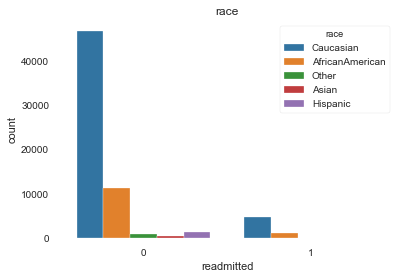

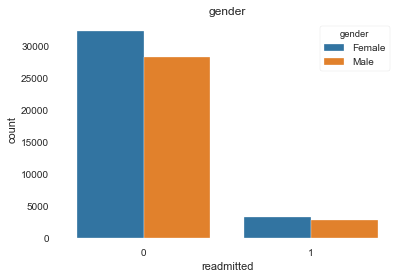

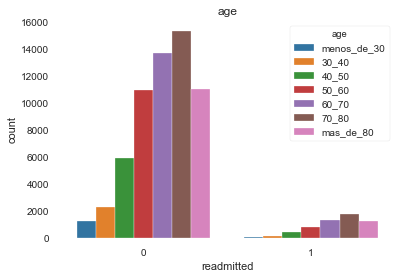

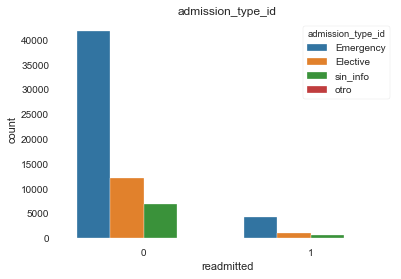

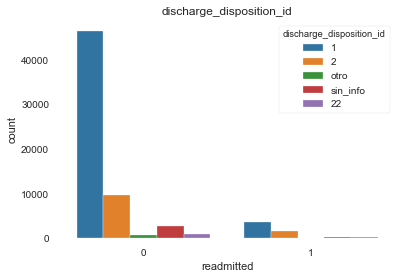

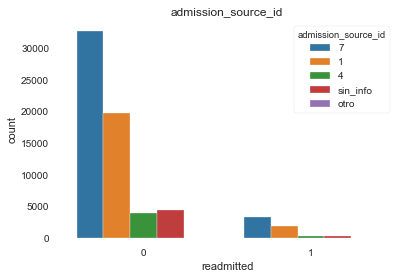

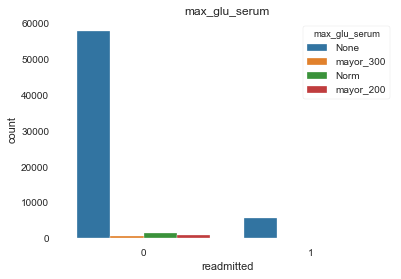

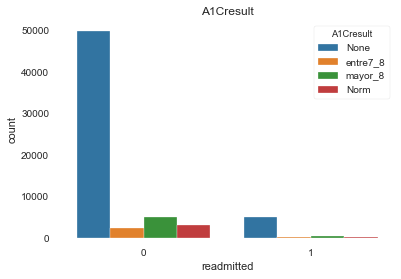

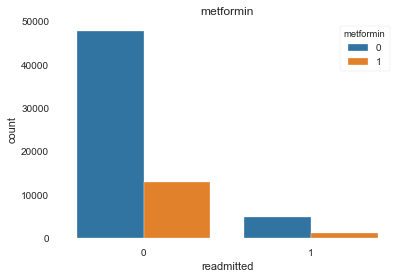

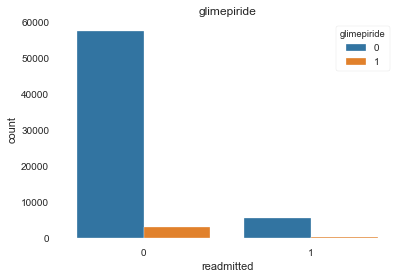

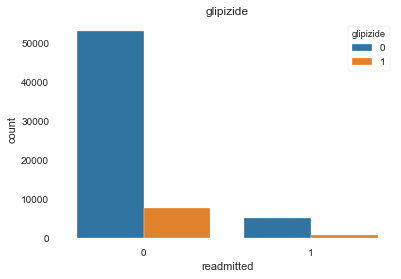

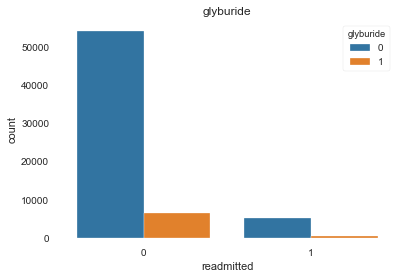

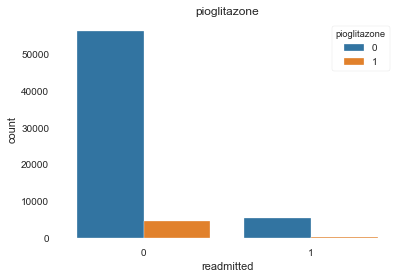

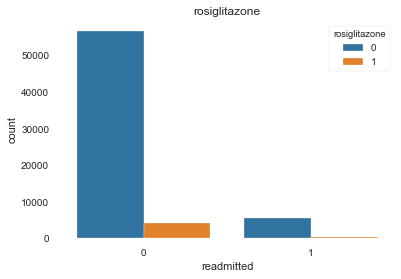

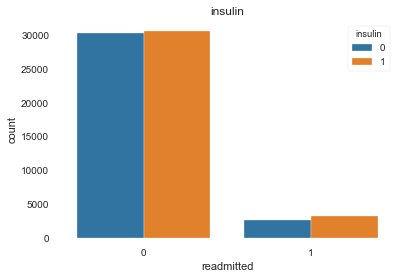

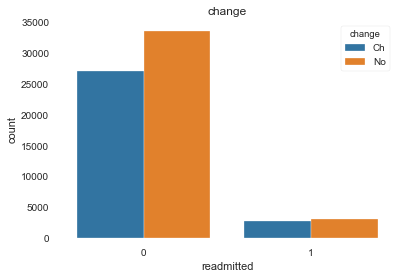

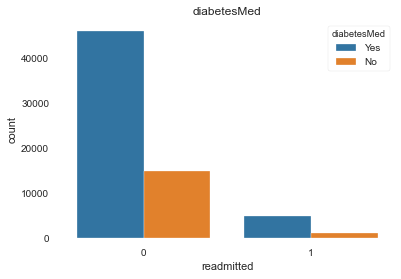

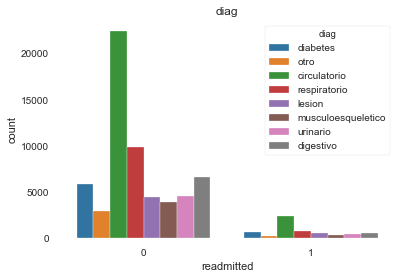

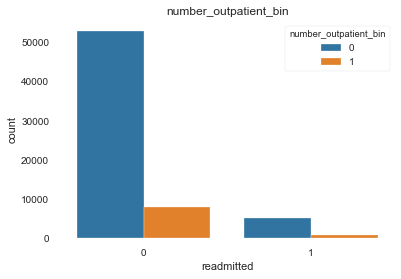

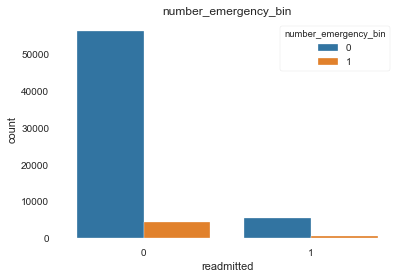

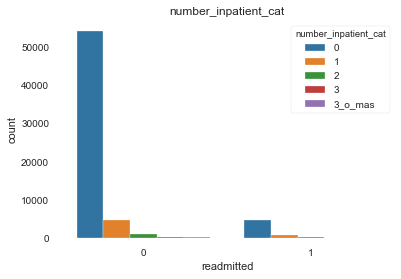

In [28]:
print("=========================================================================")
for x in cuali_vars:
    sns.countplot(x = target, hue = x, data = df)
    plt.title(x)
    plt.show()
    print("=========================================================================")

In [29]:
(
    df
    .groupby([target])[cuant_vars]
    .agg(['mean', np.std])
)

time_in_hospital           num_lab_procedures             \
                       mean       std               mean        std   
readmitted                                                            
0                  4.250967  2.925544          42.735869  19.992372   
1                  4.813632  3.063439          44.940402  19.366088   

           num_procedures           num_medications            \
                     mean       std            mean       std   
readmitted                                                      
0                1.440899  1.763489       15.681663  8.252703   
1                1.437603  1.736506       16.712381  8.336854   

           number_diagnoses           num_med_selected            
                       mean       std             mean       std  
readmitted                                                        
0                  7.303872  1.900252         1.185440  0.948493  
1                  7.580507  1.772465         1.222917  0.907383

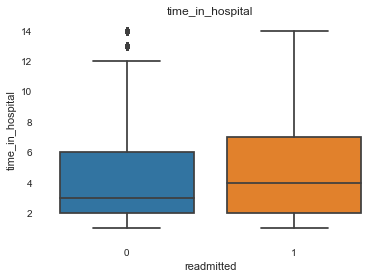

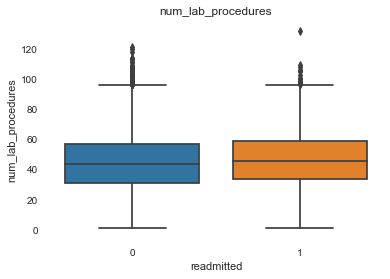

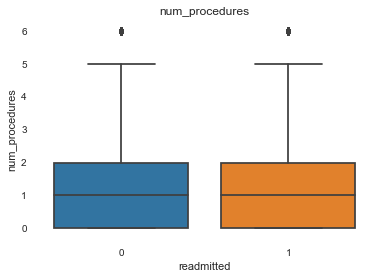

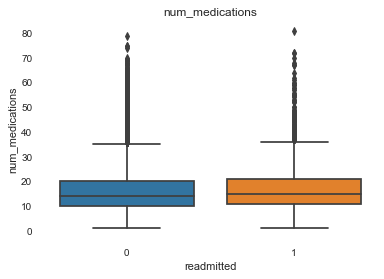

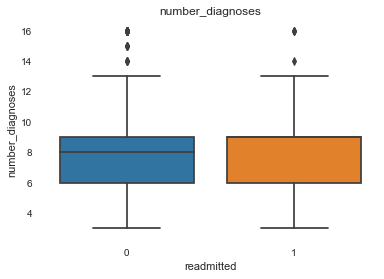

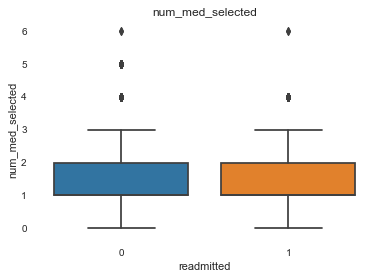

In [30]:
print("=========================================================================")
for x in cuant_vars:
    sns.boxplot(x = target, y = x, data = df)
    plt.title(x)
    plt.show()
    print("=========================================================================")

### Dataset para el modelo

In [31]:
var_to_dummies = [x for x in cuali_vars if x not in med_cols and 'bin' not in x]

In [32]:
X = pd.get_dummies(df, columns = var_to_dummies)
cols_drop = [x for x in X.columns if 'sin_info' in x or 'None' in x] #or 'discharge_disposition' in x]
X = X.drop(columns = cols_drop)

In [33]:
y = X[target]
X = X.drop(columns = target)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

In [35]:
print(X_train.shape)
print(X_test.shape)

(46790, 63)
(20053, 63)


### Modelación

**Random Forest**

Como primera propuesta ajuste un modelo Random Forest, obteniendo los siguientes resultados:

*Tuneo de Hyperparametros*

In [36]:
      # ===========  Specification Hyper-parameters of model  ===========
max_depth_vec = np.arange(8, 15, 1) 
min_samples_split_vec = np.arange(50, 95, 10)
min_samples_leaf_vec =  np.arange(5, 25, 5)
max_leaf_nodes_vec = np.arange(20, 25, 1)
min_impurity_decrease_vec = [0, 0.001, 0.002, 0.05, 0.1] 
criterion_vec = ['entropy', 'gini']

parametros = {'max_depth': max_depth_vec,                       # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
              'min_samples_split': min_samples_split_vec,       # prepoda: el mínimo número de registros necesarios para crear una nueva rama
              'min_samples_leaf': min_samples_leaf_vec,         # prepoda: el mínimo número de registros en una hoja
              'max_leaf_nodes': max_leaf_nodes_vec,             # prepoda: máximo número de nodos hojas
              'min_impurity_decrease': min_impurity_decrease_vec, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
              'criterion': criterion_vec                        # el criterio de particionamiento de un conjunto de datos
             }

params_set = {
             'n_estimators' : 100,    # Número de modelos a crear   
             'max_features' : 'auto', # Número o % de atributos de la muestra de aprendizaje
             'bootstrap' : True,      # Utilizar reemplazo en el muestreo de los registros de aprendizaje
             'oob_score' : True,      # Evaluar cada modelo con los registros no utilizados en su aprendizaje
             'n_jobs' : -1,           # Número de cores a utilizar
             'random_state' : 1234,   # random seed para el generador aleatorio
             'verbose' : 0            # controla la cantidad de información a reportar
             }

            # ===========  Specification metrics to compute  ===========
scoring = {'accuracy':'accuracy',
           'precision':'precision',
           'recall': 'recall',
           'F1': 'f1'}

            # ===========  Specification Classifier  ===========            
rforest = RandomForestClassifier(**params_set)

            # ===========  Tuning hyper-parameters  ===========
# Searching in the complete grid
grid = RandomizedSearchCV(rforest,
                         parametros,
                         cv = 3,
                         n_iter = 50,
                         scoring = scoring,
                         refit = 'recall',
                         n_jobs = -1
                         )
# Searching the best model
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100, n_jobs=-1,
                                                    oob

In [38]:
# Best Params of Model
grid.best_params_

{'min_samples_split': 50,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': 20,
 'max_depth': 8,
 'criterion': 'gini'}

In [39]:
best_hyper_fit = {'min_samples_split': 50,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': 20,
 'max_depth': 8,
 'criterion': 'gini'}

best_hyper = params_set.copy()
best_hyper.update(best_hyper_fit)

*Re ajuste con los hyperparametros obtenidos*

In [40]:
rforest = RandomForestClassifier(**best_hyper)
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=20,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=1234, verbose=0,
                       warm_start=False)

*Evaluación del modelo*

In [61]:
# Predict test dataset
y_pred = rforest.predict(X_test)
# Predict train dataset
y_pred_train = rforest.predict(X_train)
# Confusion matrix
cm = metrics.confusion_matrix(y_pred, y_test)
cm

array([[18237,  1816],
       [    0,     0]], dtype=int64)

In [62]:
# Metrics: accuracy and kappa respectively for test dataset
acc_test = metrics.accuracy_score(y_test, y_pred)
k_test = metrics.cohen_kappa_score(y_test, y_pred)
print("Exactitud test: ", acc_test)
print("Kappa test: ", k_test)
print(metrics.classification_report(y_test, y_pred, digits = 5))

# Metrics: accuracy for train dataset
acc_train = metrics.accuracy_score(y_train, y_pred_train)
print("Exactitud: ", acc_train)

acc_train - acc_test

Exactitud test:  0.909439984042288
Kappa test:  0.0
              precision    recall  f1-score   support

           0    0.90944   1.00000   0.95257     18237
           1    0.00000   0.00000   0.00000      1816

    accuracy                        0.90944     20053
   macro avg    0.45472   0.50000   0.47629     20053
weighted avg    0.82708   0.90944   0.86631     20053

Exactitud:  0.9089976490703142


-0.0004423349719737679

Como se observa en los resultados obtenidos, este modelo no presenta un buen ajuste, el acuraccy es del 90%, pero esta no es una buena metrica en estos casos donde hay presencia de desbalanceo. Incluso al calcular que el Kappa, obtenemos que es cero, lo que indica que este modelo es igual que el baseline (categoría mayoritaria).

Por lo anterior, se podria pensar en utilizar algún algoritmo de balanceo **(lo cual me gustaria discutirlo)**, sin embargo, el modelo XGBoost también funciona bien en casos de desbalanceo, especificamente si modelamos el hyperparametro de escala, donde buscamos darle un peso más alto a nuestra categoría minoritaria.

###  XGBoost Model

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
N_ITER  = 10
PARAM_SCALE_POS = np.ceil(y_train.shape[0] / y_train.sum()).astype(int)

scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'neg_log_loss': 'neg_log_loss'}

params_eval = {
                'max_depth': range(1, 5, 1),
                'min_child_weight': range(1, 6, 1),
                'learning_rate': np.arange(0, 0.55, 0.025),
                'colsample_bytree': np.arange(0.3, 0.7, 0.05)
}

params_set = {
                'n_estimators': 300,
                'subsample': 0.8,
                #'colsample_bytree': 0.8,
                'nthread': 4,
                'objective': 'binary:logistic',
                'scale_pos_weight': PARAM_SCALE_POS,
                'n_jobs': 10,
                'seed': None
}

In [45]:
xgb_model1 = xgb.XGBClassifier(**params_set)
gsearch1 = RandomizedSearchCV(
                        estimator           = xgb_model1,
                        param_distributions = params_eval,
                        n_iter  = N_ITER,
                        scoring = scoring,
                        refit   = 'neg_log_loss',
                        n_jobs  = -1,
                        cv      = 3,
                        verbose = 0)

time1 = datetime.now()
gsearch1.fit(X_train, y_train)
time2 = datetime.now()

print(time2 - time1)

0:01:04.740418


In [46]:
gsearch1.best_params_

{'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.42500000000000004,
 'colsample_bytree': 0.6499999999999999}

In [47]:
best_hyper_fit = {'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.42500000000000004,
 'colsample_bytree': 0.6499999999999999}

In [48]:
best_hyperparams = params_set.copy()
best_hyperparams.update(best_hyper_fit)

xgb_model1 = xgb.XGBClassifier(**best_hyperparams)

# Fit model
xgb_model1.fit(X_train, y_train, eval_metric = ['aucpr'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6499999999999999, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.42500000000000004, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=10, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=11, seed=0, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
# Predict test dataset
y_pred = xgb_model1.predict(X_test)
# Predict train dataset
y_pred_train = xgb_model1.predict(X_train)
# Confusion matrix
cm = metrics.confusion_matrix(y_pred, y_test)
cm

array([[11576,   845],
       [ 6661,   971]], dtype=int64)

In [68]:
# Metrics: accuracy and kappa respectively for test dataset
acc_test = metrics.accuracy_score(y_test, y_pred)
k_test = metrics.cohen_kappa_score(y_test, y_pred)
print("Exactitud test: ", acc_test)
print("Kappa test: ", k_test)
print(metrics.classification_report(y_test, y_pred, digits = 5))

# Metrics: accuracy for train dataset
acc_train = metrics.accuracy_score(y_train, y_pred_train)
print("Exactitud: ", acc_train)

acc_train - acc_test

Exactitud test:  0.625691916421483
Kappa test:  0.0693916804932716
              precision    recall  f1-score   support

           0    0.93197   0.63475   0.75517     18237
           1    0.12723   0.53469   0.20555      1816

    accuracy                        0.62569     20053
   macro avg    0.52960   0.58472   0.48036     20053
weighted avg    0.85909   0.62569   0.70540     20053

Exactitud:  0.66896772814704


0.043275811725556945

Este modelo presenta un mejor desempeño, pero para interpretar las metricas ajustemos un modelo final en el que seleccionemos las variables más importantes.

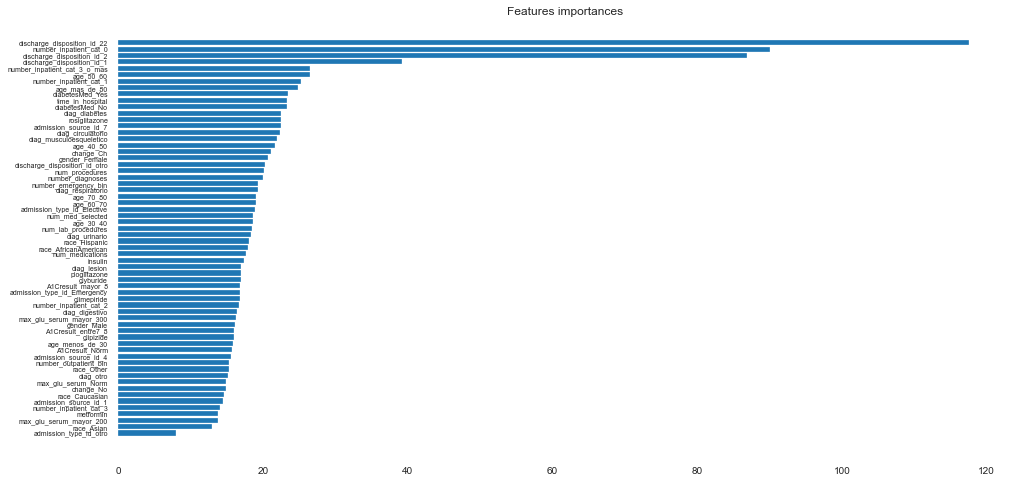

In [50]:
# Importances variables
importances_features1 = xgb_model1.get_booster().get_score(importance_type = "gain")
importances_features1 = pd.DataFrame.from_dict(importances_features1, orient = 'index')

importances_features1.reset_index(inplace = True)
importances_features1.columns = ['variable', 'value']

importances_features1 = importances_features1.sort_values('value', ascending = True)

plt.figure(figsize = (16, 8))
plt.title("Features importances")
plt.barh(range(importances_features1.shape[0]), importances_features1['value'])
plt.yticks(range(importances_features1.shape[0]), importances_features1['variable'], fontsize = 7)
plt.show()

In [83]:
vec_var = importances_features1.loc[importances_features1['value'] >= 20, 'variable']
vec_var = list(vec_var)

In [115]:
print(len(vec_var))

21


### Ajuste con las variables seleccionadas

In [104]:
X_train_final = X_train[vec_var].copy()
X_test_final = X_test[vec_var].copy()

In [89]:
xgb_model2 = xgb.XGBClassifier(**params_set)
gsearch2 = RandomizedSearchCV(
                        estimator           = xgb_model2,
                        param_distributions = params_eval,
                        n_iter  = N_ITER,
                        scoring = scoring,
                        refit   = 'neg_log_loss',
                        n_jobs  = -1,
                        cv      = 3,
                        verbose = 0)

time1 = datetime.now()
gsearch2.fit(X_train_final, y_train)
time2 = datetime.now()

print(time2 - time1)

0:00:52.975003


In [90]:
gsearch2.best_params_

{'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.2,
 'colsample_bytree': 0.5999999999999999}

In [91]:
best_hyper_fit = {'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.2,
 'colsample_bytree': 0.5999999999999999}

In [107]:
best_hyperparams = params_set.copy()
best_hyperparams.update(best_hyper_fit)

xgb_model2 = xgb.XGBClassifier(**best_hyperparams)

# Fit model
xgb_model2.fit(X_train_final, y_train, eval_metric = ['aucpr'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5999999999999999, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=10, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=11, seed=0, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
# Predict test dataset
y_pred = xgb_model2.predict(X_test_final)
y_pred_proba = xgb_model2.predict_proba(X_test_final)[:,1]

In [109]:
# Predict train dataset
y_pred_train = xgb_model2.predict(X_train_final)
# Confusion matrix
cm = metrics.confusion_matrix(y_pred, y_test)
print('Matriz de confusion: \n', cm)

Matriz de confusion: 
 [[11152   827]
 [ 7085   989]]


In [110]:
# Metrics: accuracy and kappa respectively for test dataset
acc_test = metrics.accuracy_score(y_test, y_pred)
k_test = metrics.cohen_kappa_score(y_test, y_pred)
print("Accuracy test: ", acc_test)
# Metrics: accuracy for train dataset
acc_train = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy train: ", acc_train)
print('Diferencia entre el accuracy del train y del test:', acc_train - acc_test)
print('')
print("Kappa test: ", k_test)
print('')
auc_test = roc_auc_score(y_test, y_pred_proba)
print('AUC test:', auc_test)
print('')
print(metrics.classification_report(y_test, y_pred, digits = 5))

Accuracy test:  0.60544556924151
Accuracy train:  0.6330626202179953
Diferencia entre el accuracy del train y del test: 0.027617050976485258

Kappa test:  0.06118403898257585

AUC test: 0.6113849368049029

              precision    recall  f1-score   support

           0    0.93096   0.61150   0.73815     18237
           1    0.12249   0.54460   0.20000      1816

    accuracy                        0.60545     20053
   macro avg    0.52673   0.57805   0.46908     20053
weighted avg    0.85775   0.60545   0.68942     20053



Finalmente, obtenemos un modelo mas parsimonioso con 21 variables, vemos que las metricas se mantienen con respecto al anterior modelo, lo cual es bueno.

Ahora bien, se observa que obtenemos un kappa de 0.061, lo que nos indica que este modelo es ligeramente superior al baseline (predecir la categoría mayoritaria). También se observa que no se presenta sobreajuste, pues la diferencia entre el accuracy del conjunto de entrenamiento y el conjunto test son muy similares (aqui podriamos profundizar un poco más calculando de las curvas de aprendizaje, pero esta diferencia entre accuracys es una manera sencilla y rápida de ver si hay evidencia de sobreajuste).

Por otro lado, la capacidad de este modelo de predecir bien a las personas que serán readmitidas tempranamente es del 54%, sin embargo, de todas las personas que predicen que serán readmitidas en menos de 30 días, el 12% realmente lo es, por lo que en esta situación se debe validar con la persona experta en salud, cual de estas dos métricas podría ser más importante, pues en todo el ejercicio decidí optimizar con base en el recall, pensando en la importancia de lograr predecir a todos aquellos que realmente son readmitidos en menos de 30 días.

### Interpretación del modelo

Ahora bien, con el fin de aproximarnos al efecto que tiene cada variable sobre la predicción de la readmisión temprana, se presenta el gráfico de Shap values, para identificar los insights más importantes.

In [111]:
shap_values = shap.TreeExplainer(xgb_model2).shap_values(X_test_final)

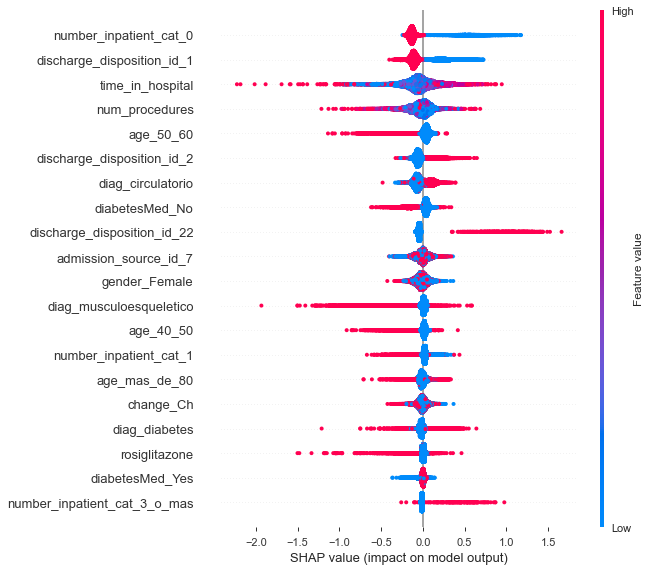

In [113]:
shap.summary_plot(shap_values, X_test_final)

Interpretemos las variables:

```number_inpatient_cat_0```: Esta es una variable binaria, que es 1 cuando el paciente tiene visitas hospitalarias en el año anterior y es 0 en caso que tenga al menos una visita. Observemos que el hecho que un paciente tenga al menos una visita hospitalaria en el año anterior incrementa la probabilidad de ser readmitido en menos de 30 días, seguramente son personas que ya han tenido situaciones de salud complejas en periodos anteriores.

```discharge_disposition_id_1```: Las personas que no son dadas de alta para la casa, incrementa la probabilidad de que sea readmitida en menos de 30 días, por el contrario cuando observamos el efecto de ```discharge_disposition_id_2```, se evidencia que aquellos pacientes que son trasladados a otros centros de atención hospitalaria, tienen mayor probabilidad de ser readmitidos en menos de 30 días.